- $\lambda_x$ is the scaling of the along-gradient component of the kernel. Typically, the steeper the gradient at $x$, the larger the resulting change in log-posterior between the proposed value $y$ and the current value $x$.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal, norm
from utils import normalize
from numpy.linalg import cholesky, inv, eigh, cholesky, solve, det
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import LinAlgError

In [2]:
def hug(T, B, x0, p, logpi, grad_log_pi):
    """
    Hug kernel.
    
    T : Float
        Integration time.
    B : Int
        Number of steps
    x0 : Numpy Array
         Initial point.
    p : Callable
        Symmetric proposal density for the velocity. Notice that in the paper this is called q.
        I have called it p to not create confusion with the constraint defining the manifold.
    """
    # Step size
    delta = T/B # int(T / B)
    # Draw velocity
    p = multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
    v0 = p.rvs()
    # Housekeeping
    v = v0
    x = x0
    # Acceptance ratio
    logu = np.log(np.random.rand())
    
    for b in range(B):
        # Move
        x = x + delta*v/2 
        # Reflect
        g = grad_log_pi(x)
        ghat = g / np.linalg.norm(g)
        v = v - 2*(v @ ghat) * ghat
        # Move
        x = x + delta*v/2
    
    if logu <= logpi(x) + p.logpdf(v) - logpi(x0) - p.logpdf(v0):
        return (x, v, 1)   # 1 means accepted
    else:
        return (x0, v0, 0)  # 0 means rejected

In [3]:
def hop(x, grad_log_pi, l, k, logpi):
    """
    Hop kernel.
    
    x : Numpy Array
        Starting point
    grad_log_pi : callable
                  Gradient of log target distribution. This is called g in the paper.
    l : Float
        Lambda
    k : Float
        Kappa
    """
    # μ, μ^2 and λ^2
    mu_sq = k * l
    mu = np.sqrt(mu_sq)
    l_sq = l**2
    
    # For MH step
    logu = np.log(np.random.rand())
    
    # Gradient, its norm and nornmalized gradient
    gx = grad_log_pi(x)
    gx_norm = np.linalg.norm(gx)
    gxhat = gx / gx_norm
    
    # B^{1/2}
    B_sqrt = (mu*np.eye(2) + (l - mu)*np.outer(gxhat, gxhat)) / np.sqrt(1 + gx_norm**2)
    
    # Sample 
    v = multivariate_normal(mean=np.zeros(2), cov=np.eye(2)).rvs()
    
    # Proposal
    y = x + (B_sqrt @ v)
    
    # Compute gradient stuff at y
    gy = grad_log_pi(y)
    gy_norm = np.linalg.norm(gy)
    gyhat = gy / gy_norm
    xmy_norm = np.linalg.norm(x - y) # ||x - y||
    
    # Accept-Reject
    logr = logpi(y) - logpi(x) + np.log((gy_norm**2) / (gx_norm**2))
    logr = logr - (1/(2*mu_sq)) * (np.linalg.norm(y-x)**2)*((gy_norm**2) - (gx_norm**2))
    logr = logr - 0.5*((1/l_sq) - (1/mu_sq)) * (((y - x) @ gy)**2 - ((y - x) @ gx)**2)
    if logu <= min(0, logr):
        # Accept
        return y, 1
    else:
        return x, 0

In [4]:
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
p = multivariate_normal(np.zeros(2), np.eye(2))
grad_log_pi = lambda xy: - inv(Sigma) @ xy

T = 0.1 #3#10.0
B = 5 #1 #3
N = 100000
# l = 5, k = 20 doesn't explore enough contours. AHug: 0.999, AHop: 0.1478
# l = 5, k = 100 AHug: 0.9982, AHop: 0.0758
# l = 5, k = 5 AHug: 0.9974, AHop: 0.2594
# l = 5, k = 3 AHUg: 0.998, AHop: 0.281
# l = 5, k = 1 AHug: 0.9974, AHop: 0.3662
# l = 0.5 - 0.81
# l = 0.5 - 0.71
# l = 0.5 - 0.61
l = 2.0     
k = 1.0 #0.5

x = target.rvs()
samples = x

acceptance_hug = np.zeros(N)
acceptance_hop = np.zeros(N)

for i in range(N):
    # Choose which kernel to use
    x_hug, v, ahug = hug(T, B, x, p, target.logpdf, grad_log_pi)
    x, ahop = hop(x_hug, grad_log_pi, l, k, target.logpdf)
    samples = np.vstack((samples, x_hug))
    samples = np.vstack((samples, x))
    acceptance_hug[i] = ahug
    acceptance_hop[i] = ahop
    
print("l/k: ", l/k)
print("Acceptance Hug: ", np.sum(acceptance_hug) / N)
print("Acceptance Hop: ", np.sum(acceptance_hop) / N)

l/k:  2.0
Acceptance Hug:  0.99995
Acceptance Hop:  0.49728


# Diagnostics - Joint

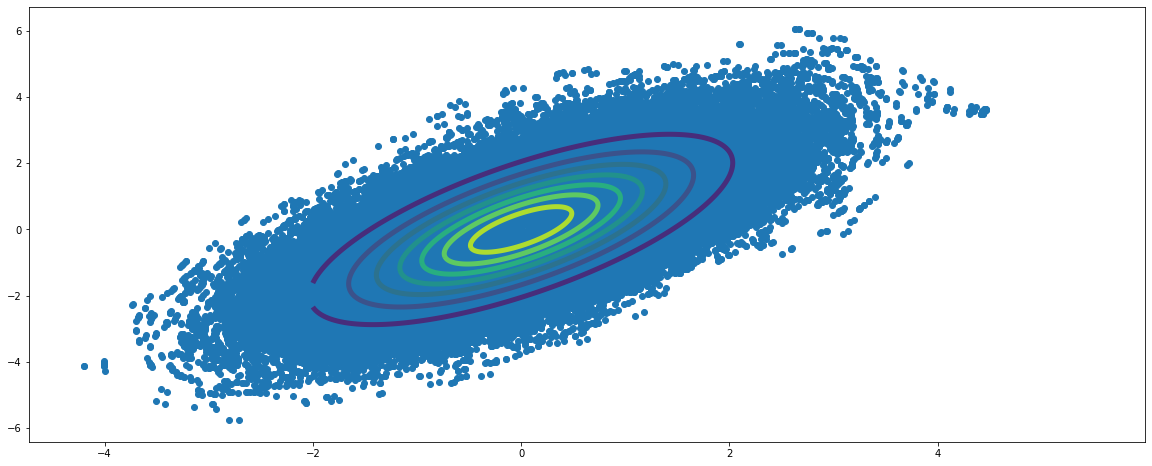

In [5]:
xlow = -2.0
xhigh = 6.0
ylow = -3.0
yhigh = 5.0
x, y = np.mgrid[xlow:xhigh:.01, ylow:yhigh:.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=5) 
ax.scatter(*samples.T)
plt.show()

# Diagnostics - Marginals

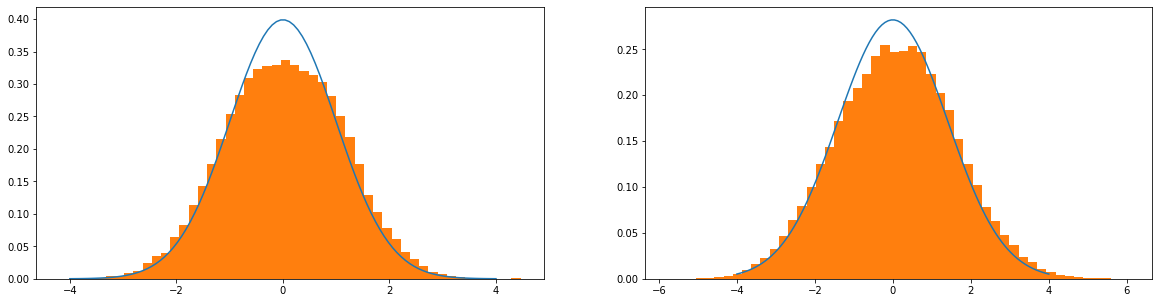

In [6]:
marginal_x = lambda x: norm(loc=mu[0], scale=np.sqrt(Sigma[0, 0])).pdf(x)
marginal_y = lambda y: norm(loc=mu[1], scale=np.sqrt(Sigma[1, 1])).pdf(y)

xx = np.linspace(-4, 4, num=100)

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].plot(xx, marginal_x(xx))
_ = ax[0].hist(samples[:, 0], density=True, bins=50)
ax[1].plot(xx, marginal_y(xx))
_ = ax[1].hist(samples[:, 1], density=True, bins=50)


# Hessian HH

In [11]:
def hugH(T, B, x0, p, logpi, grad_log_pi, S):
    """
    Hug kernel.
    
    T : Float
        Integration time.
    B : Int
        Number of steps
    x0 : Numpy Array
         Initial point.
    p : Callable
        Symmetric proposal density for the velocity. Notice that in the paper this is called q.
        I have called it p to not create confusion with the constraint defining the manifold.
    S : Numpy Array
        Approximation to the covariance matrix of the target. This should be Sigma where Sigma 
        is defined in the paper.
    """
    # Step size
    delta = T/B # int(T / B)
    # Draw velocity
    p = multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
    v0 = p.rvs()
    # Housekeeping
    v = v0
    x = x0
    # Acceptance ratio
    logu = np.log(np.random.rand())
    
    for b in range(B):
        # Move
        x = x + delta*v/2 
        # Reflect
        g = grad_log_pi(x)
        v = v - (2*(v @ g) * (S @ g)) / (g @ S @ g)
        # Move
        x = x + delta*v/2
    
    if logu <= logpi(x) + p.logpdf(v) - logpi(x0) - p.logpdf(v0):
        return (x, v, 1)   # 1 means accepted
    else:
        return (x0, v0, 0)  # 0 means rejected

In [12]:
def hopH(x, grad_log_pi, l, k, logpi, A, S):
    """
    Hop kernel.
    
    x : Numpy Array
        Starting point
    grad_log_pi : callable
                  Gradient of log target distribution. This is called g in the paper.
    l : Float
        Lambda
    k : Float
        Kappa
    """
    # μ, μ^2 and λ^2
    mu_sq = k * l
    mu = np.sqrt(mu_sq)
    l_sq = l**2
    
    # For MH step
    logu = np.log(np.random.rand())
    
    # Gradient, its norm and nornmalized gradient
    gx = grad_log_pi(x)
    gx_norm = np.linalg.norm(gx)
    gxhat = gx / gx_norm
    gtx = A @ gx   # g tilde x
    gtx_norm = np.linalg.norm(gtx)
    
    
    # Denominator
    denom = gx @ S @ gx
    
    # B
    B = (mu_sq*S + (l_sq - mu_sq) * (S @ np.outer(gx, gx) @ S.T) / denom) / denom
    B_sqrt = cholesky(B)
    
    # Hessian
    H = -inv(S)
    
    # Sample 
    v = multivariate_normal(mean=np.zeros(2), cov=np.eye(2)).rvs()
    
    # Proposal
    y = x + (B_sqrt @ v)
    
    # Compute gradient stuff at y
    gy = grad_log_pi(y)
    gy_norm = np.linalg.norm(gy)
    gyhat = gy / gy_norm
    gty = A @ gy
    gty_norm = np.linalg.norm(gty)
    xmy_norm = np.linalg.norm(x - y) # ||x - y||
    
    # Accept-Reject
    # I am assuming S(x) = S(y) = S hence 0.5*log(det(S(x)) / det(S(y))) doesn't appear
    logr = logpi(y) - logpi(x) + np.log((gty_norm**2) / (gtx_norm**2)) 
    logr = logr - (1/(2*mu_sq)) * ((y-x) @ ((gtx_norm**2)*H - (gty_norm**2)*H) @ (y - x))
    logr = logr - 0.5*((1/l_sq) - (1/mu_sq)) * (((y - x) @ gy)**2 - ((y - x) @ gx)**2)
    if logu <= min(0, logr):
        # Accept
        return y, 1
    else:
        return x, 0

In [13]:
# Estimate covariance matrix from samples
Sigma_hat = np.cov(samples.T)
A = cholesky(Sigma_hat).T              ### CHECK THIS A^top A = Sigma

T = 0.1 #3#10.0
B = 5 #1 #3
N = 100000
l = 2.0     
k = 1.0 #0.5

x = target.rvs()
samplesH = x

acceptance_hug = np.zeros(N)
acceptance_hop = np.zeros(N)

for i in range(N):
    # Choose which kernel to use
    x_hug, v, ahug = hugH(T, B, x, p, target.logpdf, grad_log_pi, Sigma_hat)
    x, ahop = hopH(x_hug, grad_log_pi, l, k, target.logpdf, A, Sigma_hat)
    samplesH = np.vstack((samplesH, x_hug))
    samplesH = np.vstack((samplesH, x))
    acceptance_hug[i] = ahug
    acceptance_hop[i] = ahop
    
print("l/k: ", l/k)
print("Acceptance Hug: ", np.sum(acceptance_hug) / N)
print("Acceptance Hop: ", np.sum(acceptance_hop) / N)

l/k:  2.0
Acceptance Hug:  0.67702
Acceptance Hop:  0.39504


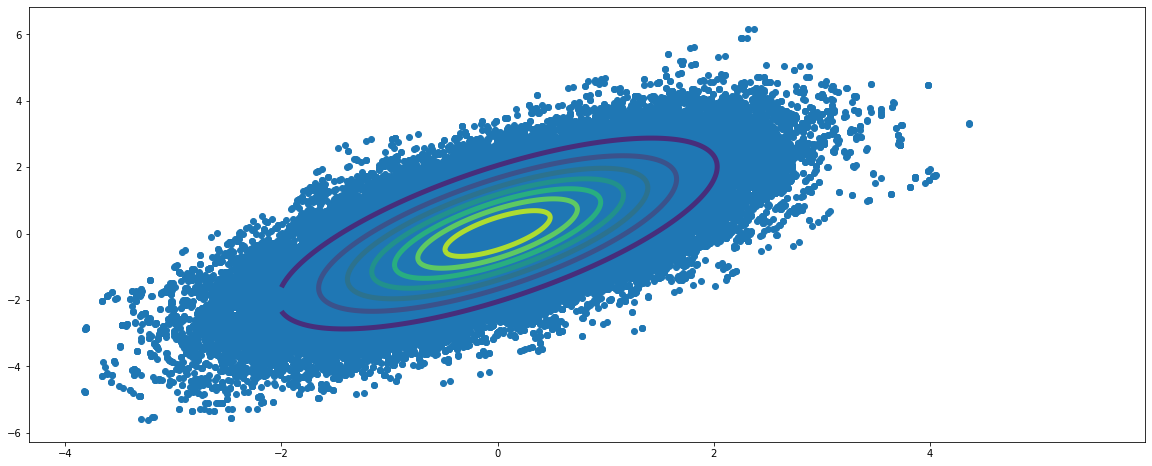

In [14]:
xlow = -2.0
xhigh = 6.0
ylow = -3.0
yhigh = 5.0
x, y = np.mgrid[xlow:xhigh:.01, ylow:yhigh:.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=5) 
ax.scatter(*samplesH.T)
plt.show()

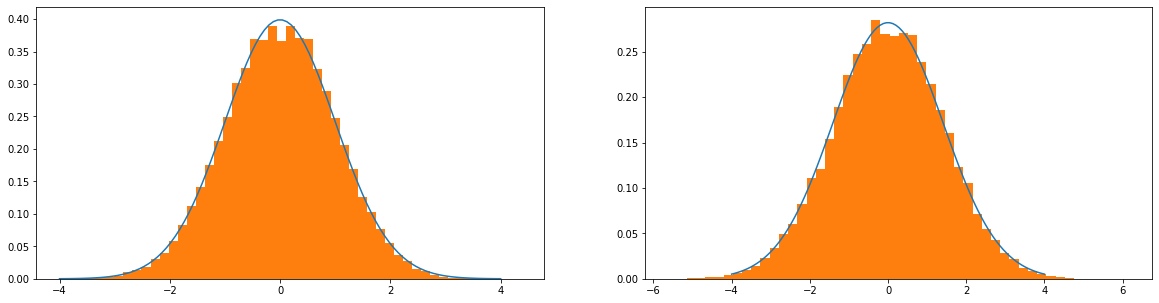

In [15]:
marginal_x = lambda x: norm(loc=mu[0], scale=np.sqrt(Sigma[0, 0])).pdf(x)
marginal_y = lambda y: norm(loc=mu[1], scale=np.sqrt(Sigma[1, 1])).pdf(y)

xx = np.linspace(-4, 4, num=100)

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].plot(xx, marginal_x(xx))
_ = ax[0].hist(samplesH[:, 0], density=True, bins=50)
ax[1].plot(xx, marginal_y(xx))
_ = ax[1].hist(samplesH[:, 1], density=True, bins=50)

# Hugging a Contour

Acceptance Rate:  1.0
Acceptance Rate:  0.975
Acceptance Rate:  0.945
Acceptance Rate:  1.0


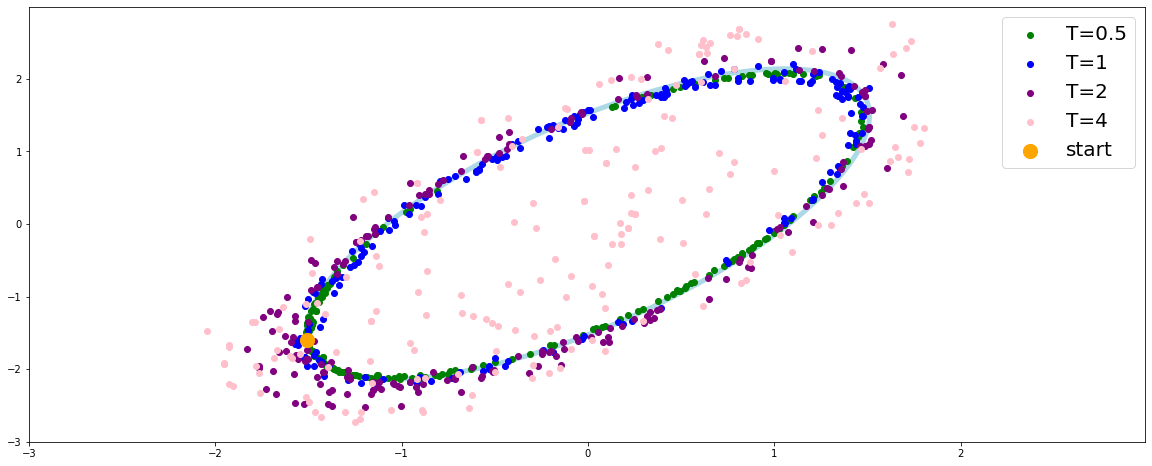

In [16]:
np.random.seed(10)
start = target.rvs()
xx = start
n = 200

# 1, 5
results1 = np.zeros(n)
samples1 = xx
for _ in range(n):
    xx, v, a = hug(1, 5, xx, p, target.logpdf, grad_log_pi)
    samples1 = np.vstack((samples1, xx))
    results1[_] = a
print("Acceptance Rate: ", sum(results1) / len(results1))
    
# 2, 5
results2 = np.zeros(n)
xx = start
samples2 = xx
for _ in range(n):
    xx, v, a = hug(2, 5, xx, p, target.logpdf, grad_log_pi)
    samples2 = np.vstack((samples2, xx))
    results2[_] = a
print("Acceptance Rate: ", sum(results2) / len(results2))

# 4, 5
results3 = np.zeros(n)
xx = start
samples3 = xx
for _ in range(n):
    xx, v, a = hug(4, 5, xx, p, target.logpdf, grad_log_pi)
    samples3 = np.vstack((samples3, xx))
    results3[_] = a
print("Acceptance Rate: ", sum(results3) / len(results3))

# 0.5, 5
results4 = np.zeros(n)
xx = start
samples4 = xx
for _ in range(n):
    xx, v, a = hug(0.5, 5, xx, p, target.logpdf, grad_log_pi)
    samples4 = np.vstack((samples4, xx))
    results4[_] = a
print("Acceptance Rate: ", sum(results4) / len(results4))


xlow = -3.0
xhigh = 3.0
ylow = -3.0
yhigh = 3.0
x, y = np.mgrid[xlow:xhigh:.01, ylow:yhigh:.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=5, levels=[target.pdf(start)], colors="lightblue") 
ax.scatter(*samples4.T, zorder=5, color="green", label="T=0.5")
ax.scatter(*samples1.T, zorder=10, color="blue", label="T=1")
ax.scatter(*samples2.T, zorder=20, color="purple", label="T=2")
ax.scatter(*samples3.T, zorder=30, color="pink", label="T=4")
ax.scatter(*start, color="orange", zorder=100, s=200, label="start")
plt.legend(fontsize=20)
plt.show()

In [17]:
aaa = np.array([1, 2])

In [19]:
len(aaa.shape)

1

In [22]:
assert len(aaa.shape) == 1, "Hello"